### Jessica Kong; Ginger Group 
### University of Washington, Seattle
#### December 1, 2018

# Software required: Python with Conda
Reference [here](https://uwdirect.github.io/software.html)
## 1. Get Python with Conda¶
1. Conda is a system for installing and managing packages and their dependencies. You can get Anaconda [here](https://docs.anaconda.com/anaconda/install/) and follow the installation instructions.

2. Go to the Anaconda prompt (just hit the windows button and search for Anaconda Prompt) and update conda's packages for your system by typing "conda update conda" into the terminal. Update suggested packages.

3. Install Jupyter notebook and its requirements by typing "conda install jupyter" in the same terminal. 

4. Type "jupyter notebook" in the terminal. A "Home" page in your browser should open. Shut down the kernel by holding "Ctrl +c" within the Anaconda Prompt.

## 2. Get dipy
Anaconda comes with many packages, but we also need dipy which is what we will use to register images.
Install Dipy by typing "conda install dipy -c conda-forge" Install nibabel if prompted. 
Type "conda list" to see all the packages to ensure dipy has been installed. 

##  3. Navigate to data folder and open a Jupyter Notebook
Make a new directory and give it a name by typing mkdir followed by the name like "mkdir ImageAlignment" in the Anaconda Prompt. Go to the directory by typing "cd ImageAlignment" Open a Jupyter Notebook by typing "jupyter notebook" and create a new notebook by clicking "New" and selecting Python 3. The name of the notebook can be changed by double clicking "Untitled."

## 4. Download data for image alignment tutorial. 

In [26]:
#PiFM topo: 
!curl -o PiFM_topo.npy https://github.com/kongjy/DipyImageAlignentTutorial/blob/master/PiFM_topo.npy
#cAFM topo:
!curl -o cAFM_topo.npy https://github.com/kongjy/DipyImageAlignentTutorial/blob/master/cAFM_topo.npy
#cAFM: 
!curl -o cAFM.npy https://github.com/kongjy/DipyImageAlignentTutorial/blob/master/cAFM.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55761    0 55761    0     0  79544      0 --:--:-- --:--:-- --:--:-- 79431
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55763    0 55763    0     0  45188      0 --:--:--  0:00:01 --:--:-- 45188
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55712    0 55712    0     0  76317      0 --:--:-- --:--:-- --:--:-- 76317


# Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#image registration
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (AffineTransform2D,
                                   RigidTransform2D,
                                   RotationTransform2D,
                                  ScalingTransform2D, 
                                   TranslationTransform2D)

# Define a simple function called `show` to visualize images with customized color limits and colorbar

In [2]:
def show(img, cmap = 'plasma', colorbar = True):
    """Displays image with colorbar."""
    fig = plt.imshow(img, cmap = cmap)
    imgstd = img.std()
    imgmean = img.mean()
    #makes color limits +/- 2 std of image mean
    ll = imgmean - (2*imgstd)
    ul = imgmean + (2*imgstd)
    plt.clim(ll,ul)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if colorbar == True:
        plt.colorbar()
    return 

# Import images

#### For this tutorial, the topography images are acquired on two different AFMs of approximately the same area. We will use the mapping obtained to register the 'cafm' topography with the 'pifm' topography to also register the current image. 

In [3]:
pifmtopo = np.load('PiFM_topo.npy')
cafmtopo = np.load('cAFM_topo.npy')
cafm = np.load('cAFM.npy')

# Display images 

#### We can see that the images are generally of the same physical location but requires registration to enable pixel-to-pixel analysis

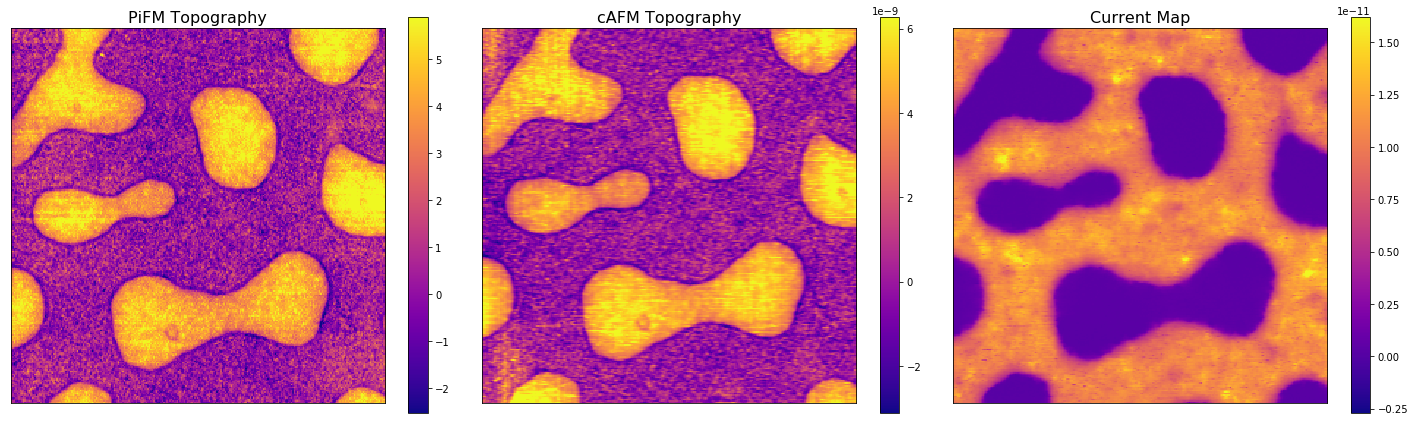

In [4]:
fig = plt.figure(1, figsize=(20,6))
plt.subplot(131)
show(pifmtopo)
plt.title('PiFM Topography', size = 16)
plt.subplot(132)
show(cafmtopo)
plt.title('cAFM Topography', size = 16)
plt.subplot(133) 
show(cafm)
plt.title('Current Map', size = 16)
plt.tight_layout()

# Image Registration
#### This tutorial follows the ideas in the example on the dipy website closely. It is [here](http://nipy.org/dipy/examples_built/affine_registration_3d.html). 

#### Before we begin, we need to define a few things: 1) Similarity metric used to evaluate how well two images are aligned;  2) Gaussian pyramid defining the optimization at multiple resolution levels, and 3) Optimization algorithm to use. 

First, we set up the similarity metric. We will use mutual information (MI). We specify the number of bins in the probability distribution functions (PDFs) used to calculate the MI to be 32. We specify that 100% of the pixels be used in computing the PDFs by setting sampling_prop as  100. Any integer in (0, 100] can be used.


In [5]:
nbins = 32
sampling_prop = 100 
metric = MutualInformationMetric(nbins, sampling_prop)

Next, we specify how the Gaussian pyramid is built. Below, we define a three-level Gaussian Pyramid containing sub-sampled topographies at quarter, half, and full resolutions. The coarsest, medium, and finest resolutions are Gaussian-smoothed with σ = 3, 1, and 0, respectively. At each of the aforementioned resolutions, 10,000, 1,000, and 100 optimization iterations will be performed. 

In [6]:
factors = [4, 2, 1]
sigmas = [3.0, 1.0, 0.0]
level_iters = [10000, 1000, 100]

Finally, we instantiate a registration class with the parameters we have specified. We also specify that a limited memory Broyden-Fletcher-Goldfarb-Shanno box (L-BFGS-B) be used. (This is default, so does not necessarily need to be specified.) For other optimization algorithms, see other available methods [here](http://nipy.org/dipy/reference/dipy.align.html?highlight=Optimizer#dipy.align.imaffine.Optimizer).

In [7]:
affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas,
                            factors=factors, method='L-BFGS-B')

As there may be several local minima, we want to register the images in multiple steps, starting with basic affine transformations (translation or rotation). We will then refine our registration in subsequent steps by utilizing the prior registration. Below, we will refine the optimization in three stages in the following order: translation, rigid, and affine using results from the previous stage. 

### **Important: A note on types of registrations and in the context of dipy**   
[Affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) is a mathemathical term for **any** combination or sequence of transformations that preserve points, straight lines and planes. Technically, an affine transformation can contain translations, scaling, reflections, rotations, shear mapping, homothety, similarity transformations, and combinations of these transformations in any sequence. It is an umbrella term for all of the aforementioned transformations. 

A [rigid transformation](https://en.wikipedia.org/wiki/Rigid_transformation) encapsulate rotations, translations, reflections, and their combinations in any sequence. All rigid transformations are affine transformations. 

All available transformations in Dipy can be found in a dictionary called `regtransforms` located in `dipy.align.transforms`. They include translation, rotation, rigid, scaling, and affine in 2 and 3 dimensional space. Within the dipy package, a rigid transformation can at most include translation, rotation and their combinations. Within this package, an affine transformation can at most include a translation, rotation, scale, shear and their combinations. 

# First, we start with optimizing a simple translation transformation in x, y-space. 

In [8]:
#specify moving and static image: 
static = pifmtopo
moving = cafmtopo
#specify type of transformation: 
transform = TranslationTransform2D() 
#specify initial parameters be None, i.e
#the transformation starts with identity matrix. 
params0 = None 
#use optimize method to find optimal translation transform
#between moving and static images
translation = affreg.optimize(static, moving, transform, params0)
#apply the transformation to the cafm topography: 
after_translation = translation.transform(moving)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


# Show images after translation transform 

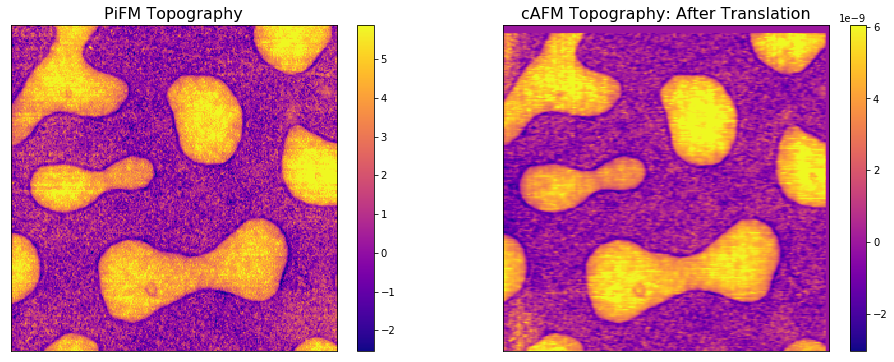

In [9]:
fig = plt.figure(1, figsize=(25,6))
plt.subplot(131)
show(static)
plt.title('PiFM Topography', size = 16)
plt.subplot(132)
show(after_translation)
plt.title('cAFM Topography: After Translation', size = 16);
plt.savefig('AfterTranslation')

# Next, we optimize with respect to translation and rotation by using the rigid transformation in dipy. 

### We will utilize the optimization found previously by specifying it in an additional argument, `starting_affine`, in the optimize method 

In [10]:
#use prior x-,y-transformation as starting point
#optimize with respect to translation and rotation.  
starting_affine = translation.affine 
transform = RigidTransform2D() 
rigid = affreg.optimize(static, moving, transform, params0, starting_affine=starting_affine)
after_rigid = rigid.transform(moving)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


# Show images after rigid transform 

## The differences are subtle but can be seen by opening the saved .png files and toggling between them. 

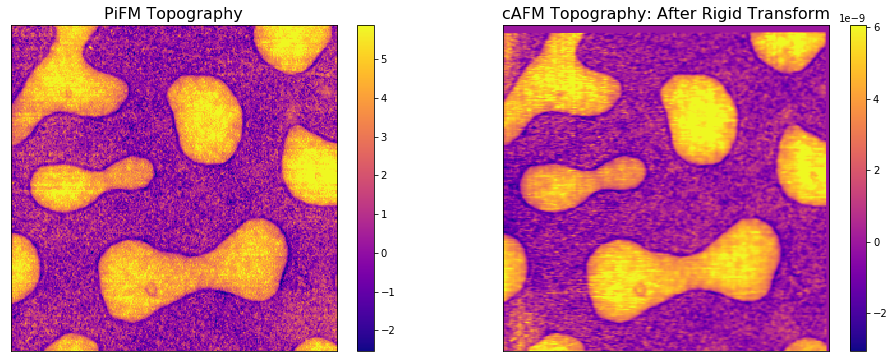

In [11]:
fig = plt.figure(1, figsize=(25,6))
plt.subplot(131)
show(static)
plt.title('PiFM Topography', size = 16)
plt.subplot(132)
show(after_rigid)
plt.title('cAFM Topography: After Rigid Transform', size = 16);
plt.savefig('AfterRigid')

# Finally, we optimize with respect to translation, rotation, and shear by using the rigid transformation in dipy. 

### Again, we will utilize the optimization found previously by specifying it in an additional argument, `starting_affine`, in the optimize method 

In [12]:
starting_affine = rigid.affine
transform = AffineTransform2D()
affine = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
after_affine = affine.transform(moving)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


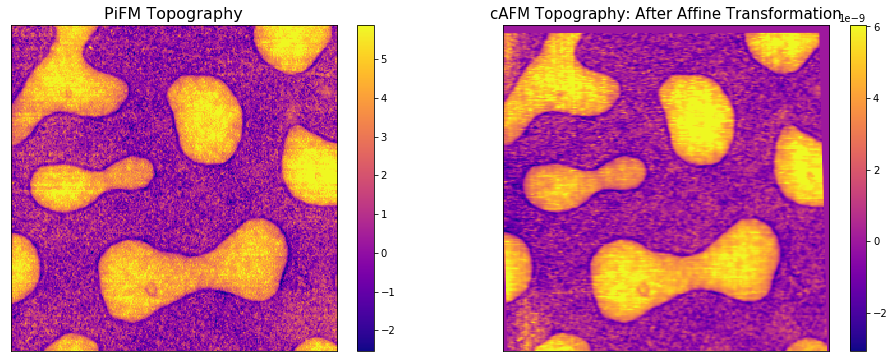

In [13]:
fig = plt.figure(1, figsize=(25,6))
plt.subplot(131)
show(static)
plt.title('PiFM Topography', size = 16)
plt.subplot(132)
show(after_affine)
plt.title('cAFM Topography: After Affine Transformation', size = 15);
plt.savefig('AfterAffine')

# Crop the images to a common area

In [14]:
cropped_pifmtopo = pifmtopo[25:,2:249]
cropped_after_affine = after_affine[25:,2:249]

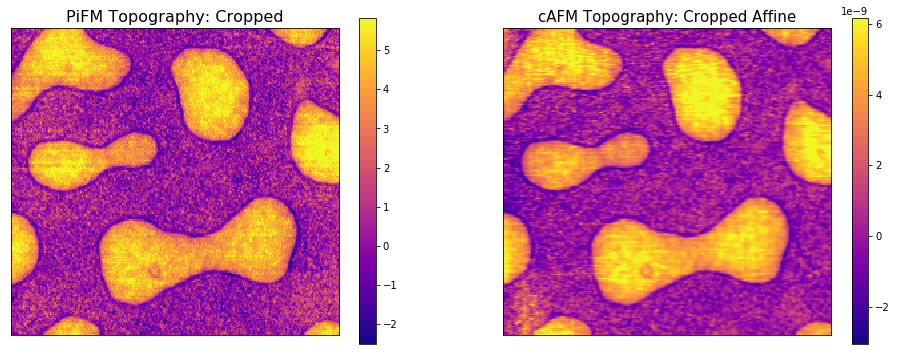

In [15]:
fig = plt.figure(1, figsize=(25,6))
plt.subplot(131)
show(cropped_pifmtopo)
plt.title('PiFM Topography: Cropped', size = 16)
plt.subplot(132)
show(cropped_after_affine)
plt.title('cAFM Topography: Cropped Affine', size = 15);
plt.savefig('AfterAffine')

# Save cropped images separately without colorbars
### Toggling between the saved .png images shows that the images have been aligned. Colorscale and imaging quality between the two images are different, a result of the differences between topography images acquired via contact and tapping modes. 

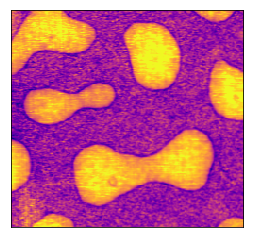

In [16]:
show(cropped_pifmtopo, colorbar=False)
plt.savefig('PiFM_crop')
show(cropped_after_affine, colorbar=False)
plt.savefig('Affine_crop')

# We register the final images above with an affine transformation with no starting affine as a sanity check.

In [17]:
static = cropped_pifmtopo
moving = cropped_after_affine
transform = AffineTransform2D()
affine_check = affreg.optimize(static, moving, transform, params0)
check = affine_check.transform(moving)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


# Show and save the image. 
## Comparing 'check' with 'affine_crop' shows the two are the same. 

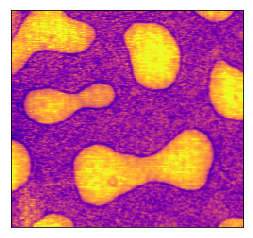

In [18]:
show(check, colorbar=False)
plt.savefig('Check')

# Finally, we apply the affine transformation to the current map and crop it to the same area. 

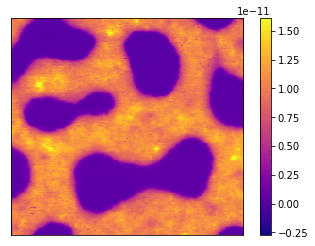

In [19]:
cafm_affine = affine.transform(cafm)
cropped_cafm_affine = cafm_affine[25:,2:249]
show(cropped_cafm_affine)

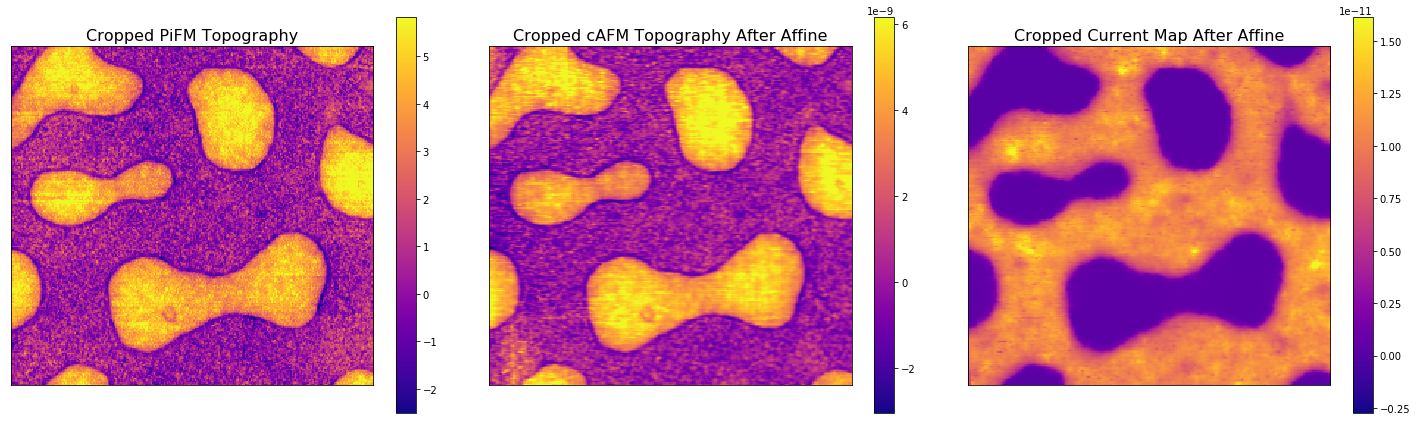

In [20]:
fig = plt.figure(1, figsize=(20,6))
plt.subplot(131)
show(cropped_pifmtopo)
plt.title('Cropped PiFM Topography', size = 16)
plt.subplot(132)
show(cropped_after_affine)
plt.title('Cropped cAFM Topography After Affine', size = 16)
plt.subplot(133) 
show(cropped_cafm_affine)
plt.title('Cropped Current Map After Affine', size = 16)
plt.tight_layout()

In [21]:
cafm_flat = np.concatenate(list(cafm))
crop_cafm_flat = np.concatenate(list(cropped_cafm_affine))

### This registration has enabled pixel-to-pixel analysis with the functional image associated with the other topography. Below, we plot the distribution of the current values of the full raw image and the cropped image after affine transformation to show that they have not been severely altered. Differences between the two distributions are most likely to be primarily a result of the cropping. 

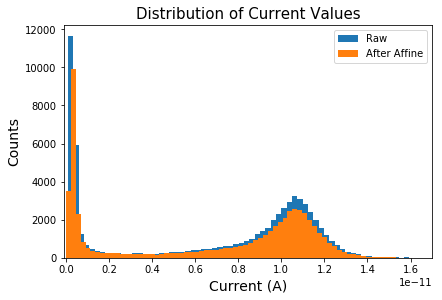

In [22]:
plt.hist(cafm_flat, bins = 100, label='Raw');
plt.hist(crop_cafm_flat, bins = 100, label='After Affine');
plt.legend()
plt.tight_layout()
plt.xlim(-1e-13, 1.7e-11)
plt.title('Distribution of Current Values', size = 15);
plt.xlabel('Current (A)', size = 14)
plt.ylabel('Counts',size = 14);